# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

### Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_ und _Deep Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.


In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from setup import setup_dataset

keras.utils.set_random_seed(100)

verification_image_dir = '../dataset/verification'
model_folder = 'models/'
model_filename = 'dog_classifier.keras'
weights_filename = 'model.weights.h5'

## Hyperparameter definieren

In [24]:
num_classes = 5
batch_size = 16
epochs = 15
learning_rate = 1e-4
resize_size = (256, 256)
indices = [0, 2, 77, 84, 55]

## Laden der Datensets

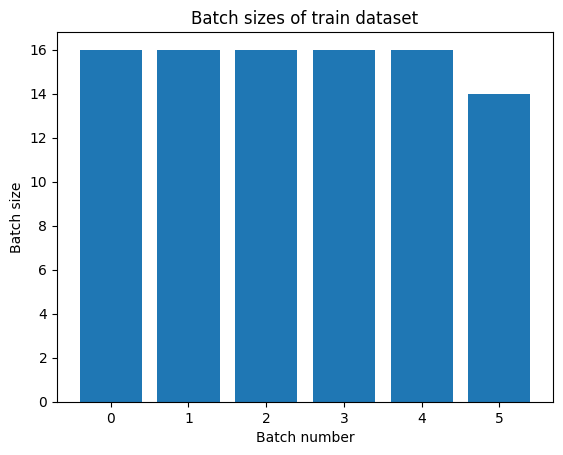

In [25]:
train_dataset, test_dataset, metadata = setup_dataset('../dataset', labels=indices)


def preprocess(img, label):
    table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(indices, dtype=tf.int64),
            values=tf.constant(list(range(num_classes)),  dtype=tf.int64),
        ),
        default_value= tf.constant(0,  dtype=tf.int64)
    )
    img = tf.image.resize(img, resize_size)
    img = img / 255.0  # Normalisierung
    label = table.lookup(label)
    return img, label

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(100)
        .batch(batch_size)
        .repeat(3)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)



def plot_batch_sizes(ds):
    batch_sizes = [np.array(batch[1]).shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.title("Batch sizes of train dataset")
    plt.xlabel("Batch number")
    plt.ylabel("Batch size")
    plt.show()

plot_batch_sizes(test_dataset)

# Model erstellen

In [26]:

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu', input_shape=(*resize_size, 3)),
        keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),

        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

/home/jakob/Documents/git/ml-lecture/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training des Models

Epoch 1/15
     26/Unknown 6s 154ms/step - accuracy: 0.2512 - loss: 3.1038

/home/jakob/Documents/git/ml-lecture/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.2529 - loss: 3.0746 - val_accuracy: 0.2553 - val_loss: 1.6795
Epoch 2/15


2024-12-12 18:42:48.335659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:42:48.335691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.3551 - loss: 2.1394 - val_accuracy: 0.3404 - val_loss: 1.5376
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5046 - loss: 1.4656 - val_accuracy: 0.4043 - val_loss: 1.4652
Epoch 4/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6095 - loss: 1.0331

2024-12-12 18:42:56.536563: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6110 - loss: 1.0288 - val_accuracy: 0.3936 - val_loss: 1.4498
Epoch 5/15


2024-12-12 18:42:56.891559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7265 - loss: 0.7669

2024-12-12 18:42:59.393366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7274 - loss: 0.7644 - val_accuracy: 0.4043 - val_loss: 1.4500
Epoch 6/15


2024-12-12 18:42:59.738308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7556 - loss: 0.6776

2024-12-12 18:43:02.255915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7580 - loss: 0.6711 - val_accuracy: 0.3830 - val_loss: 1.4468
Epoch 7/15


2024-12-12 18:43:02.611542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8315 - loss: 0.5239

2024-12-12 18:43:05.120873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8307 - loss: 0.5277 - val_accuracy: 0.3830 - val_loss: 1.4696
Epoch 8/15


2024-12-12 18:43:05.457981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:05.458013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8491 - loss: 0.4479 - val_accuracy: 0.3936 - val_loss: 1.5212
Epoch 9/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8705 - loss: 0.3727

2024-12-12 18:43:10.853215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:10.853241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8724 - loss: 0.3703 - val_accuracy: 0.3511 - val_loss: 1.5459
Epoch 10/15


2024-12-12 18:43:11.192513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:11.192545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8833 - loss: 0.3232 - val_accuracy: 0.3723 - val_loss: 1.5391
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9327 - loss: 0.2450 - val_accuracy: 0.3723 - val_loss: 1.5929
Epoch 12/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9444 - loss: 0.2600

2024-12-12 18:43:19.413466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:19.413495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9437 - loss: 0.2617 - val_accuracy: 0.4149 - val_loss: 1.5795
Epoch 13/15


2024-12-12 18:43:19.783774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:19.783810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9059 - loss: 0.2633

2024-12-12 18:43:22.331344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9069 - loss: 0.2619 - val_accuracy: 0.4255 - val_loss: 1.5873
Epoch 14/15


2024-12-12 18:43:22.690672: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:22.690705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9338 - loss: 0.2104

2024-12-12 18:43:25.202512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:25.202544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9356 - loss: 0.2082 - val_accuracy: 0.4255 - val_loss: 1.6247
Epoch 15/15


2024-12-12 18:43:25.562479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:25.562512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9592 - loss: 0.1637

2024-12-12 18:43:28.094533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:28.094562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9597 - loss: 0.1630 - val_accuracy: 0.3936 - val_loss: 1.5894


2024-12-12 18:43:28.460022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 252, 252, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 252, 252, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 252, 252, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 84, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 82, 82, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 22, 22, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,360,007 (16.63 MB)

 Trainable params: 4,359,109 (16.63 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

2024-12-12 18:43:28.825303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17080047826698313515
2024-12-12 18:43:28.825333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11283831286447593922


Test accuracy: 0.394


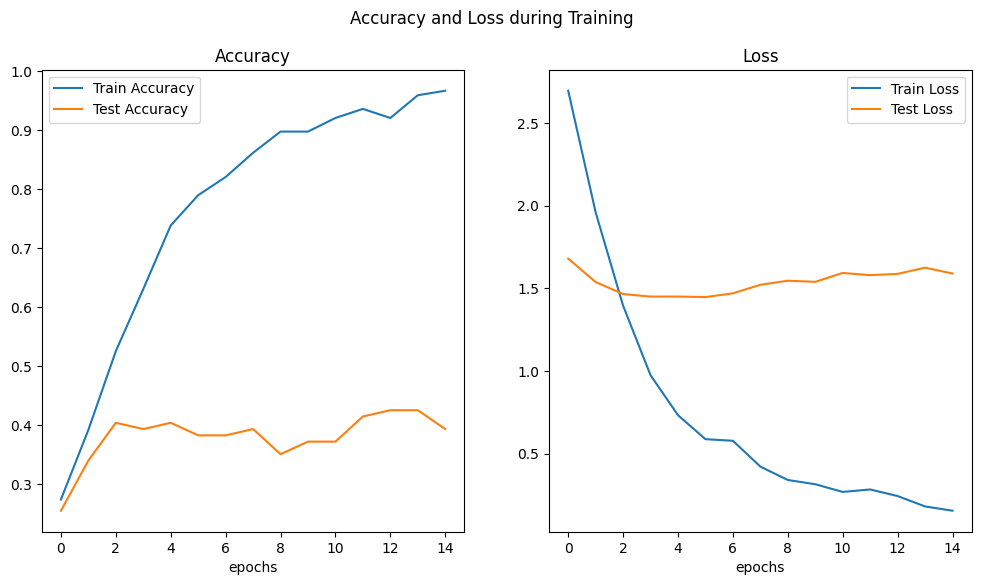

In [27]:

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1
)

#model.save_weights(os.path.join(model_folder, weights_filename))
#model.save(os.path.join(model_folder, model_filename))

model.summary()
loss, acc = model.evaluate(test_dataset, verbose=0)
print('Test accuracy: %.3f' % acc)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Accuracy and Loss during Training')

# Plot Accuracy
ax1.set_title("Accuracy")
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy')
ax1.set(xlabel="epochs")
ax1.legend()

# Plot Loss
ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Test Loss')
ax2.set(xlabel="epochs")
ax2.legend()

plt.show()

# Performancetest des Modells

In [28]:
model = keras.models.load_model(os.path.join(model_folder, model_filename))
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(img):
    img_array = tf.image.resize(img, resize_size)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(img):
    preprocessed_image = preprocess_image(img)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = keras.preprocessing.image.load_img(img)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

for img in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: (<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[0.624303  , 0.67920494, 0.47920495],
         [0.6370108 , 0.6919128 , 0.49191278],
         [0.6240919 , 0.67899394, 0.4711508 ],
         ...,
         [0.53388053, 0.58035725, 0.22891732],
         [0.50483304, 0.5782093 , 0.20734528],
         [0.5157957 , 0.5942271 , 0.22167808]],

        [[0.6172554 , 0.6721574 , 0.4721574 ],
         [0.63373464, 0.6886366 , 0.4831679 ],
         [0.6286841 , 0.68358606, 0.47574297],
         ...,
         [0.5341963 , 0.58067304, 0.22923309],
         [0.5210585 , 0.5928753 , 0.2290395 ],
         [0.5294118 , 0.60510874, 0.24076287]],

        [[0.61097497, 0.6658769 , 0.46460548],
         [0.62562805, 0.68053   , 0.4726869 ],
         [0.6297223 , 0.68526   , 0.47614542],
         ...,
         [0.5277897 , 0.57426643, 0

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int64 tensor [Op:Pack] name: images